# HSBC STOCK ANALYSIS & TRADING STRATEGY

# STEP 1 - Collect Data on your Selected Stock and the one Used for Benchmarking

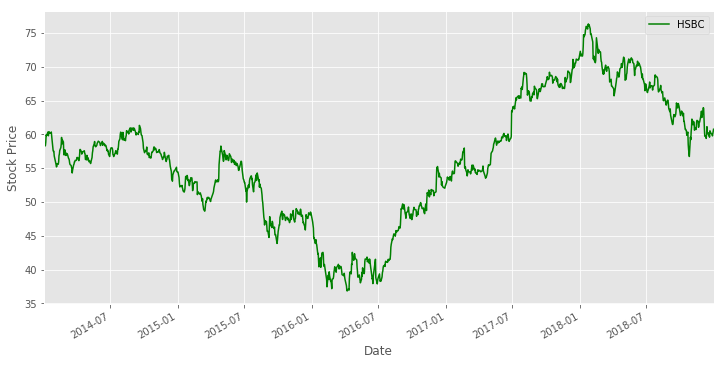

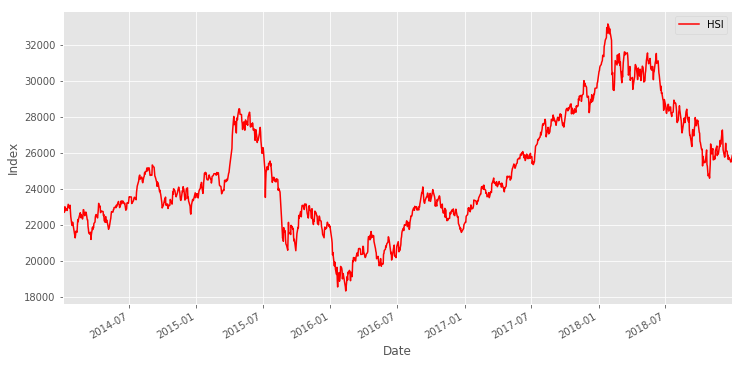

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader.data as dr
from datetime import date

#import 5-year historical HSBC stock price data (2014 - 2018) from yahoo finance
ticker = '0005.HK'
start = date(2014,1,1)
end = date(2018,12,31)
HSBC = dr.DataReader(ticker,'yahoo', start, end)

#import 5-year historical Hang Seng Index data (2014 - 2018) from yahoo finance
ticker = '^HSI'
start = date(2014,1,1)
end = date(2018,12,31)
HSI = dr.DataReader(ticker,'yahoo', start, end)

#visualise the HSBC and HSI stock price and index data
plt.style.use('ggplot')
HSBC['Adj Close'].plot(label='HSBC', figsize=(12,6), c='g' )
plt.ylabel('Stock Price')
plt.legend()
plt.show()

HSI['Adj Close'].plot(label='HSI', figsize=(12,6), c='r')
plt.ylabel('Index')
plt.legend()
plt.show()

# STEP 2: Analyze the Stock Performance

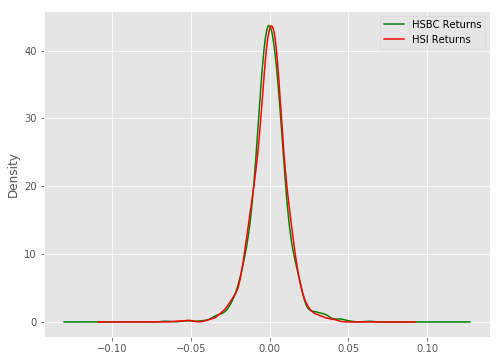

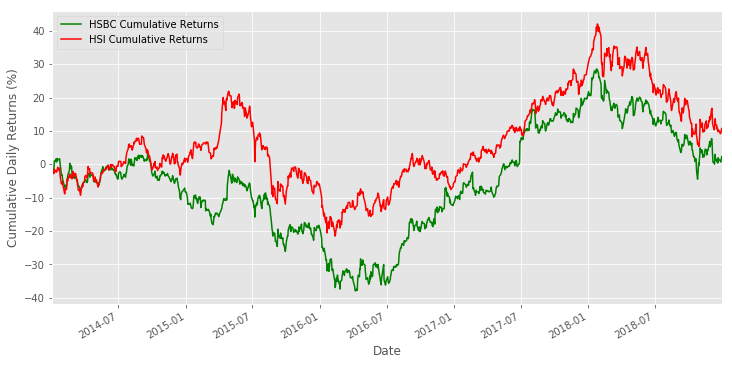

HSBC Total Return : 2.34%     HSI Total Return : 10.74%
HSBC Sharpe Ratio : 0.12      HSI Sharpe Ratio : 0.21
HSBC Max Drawdown : -39.93%   HSI Max Drawdown : -35.59%
HSBC Alpha : -0.6%
HSBC Beta : 0.76


In [2]:
#Compute the HSBC and HSI daily returns over the 5-year period
HSBC_return = pd.DataFrame(HSBC['Adj Close'].pct_change())
HSBC_return.columns = ['HSBC Returns']

HSI_return = pd.DataFrame(HSI['Adj Close'].pct_change()) 
HSI_return.columns = ['HSI Returns']

#visualize the HSBC and HSI daily returns distribution
plt.figure(figsize=(8,6))
plt.style.use('ggplot')
HSBC_return['HSBC Returns'].plot.kde(c='g')
HSI_return['HSI Returns'].plot.kde(c='r')
plt.legend()
plt.show()

#visualize the HSBC and HSI cumulative daily returns
HSBC_cum_return = ((1 + (HSBC_return)).cumprod()-1)*100
HSBC_cum_return.columns = ['HSBC Cumulative Returns']

HSI_cum_return = ((1 + (HSI_return)).cumprod()-1)*100
HSI_cum_return.columns = ['HSI Cumulative Returns']

plt.figure(figsize=(12,6))
plt.style.use('ggplot')
HSBC_cum_return['HSBC Cumulative Returns'].plot(c='g')
HSI_cum_return['HSI Cumulative Returns'].plot(c='r')
plt.ylabel('Cumulative Daily Returns (%)')
plt.legend()
plt.show()

#compute the total return,sharpe ratio and max drawdown of HSBC and HSI
import empyrical
HSI_Total_Return = empyrical.cum_returns_final(returns=HSI_return) * 100
HSBC_Total_Return = empyrical.cum_returns_final(returns=HSBC_return) * 100

HSI_Sharpe_Ratio = empyrical.sharpe_ratio(returns=HSI_return)
HSBC_Sharpe_Ratio = empyrical.sharpe_ratio(returns=HSBC_return)

HSI_Max_Drawdown = empyrical.max_drawdown(returns=HSI_return) * 100
HSBC_Max_Drawdown = empyrical.max_drawdown(returns=HSBC_return) * 100
                                           
#compute the alpha and beta of HSBC Stock
HSBC_Alpha = empyrical.alpha(returns=HSBC_return, factor_returns=HSI_return) * 100
HSBC_Beta = empyrical.beta(returns=HSBC_return, factor_returns=HSI_return)
                                           
                                           
#print the performance results
print('HSBC Total Return : ' + str(round(HSBC_Total_Return[0],2)) + '%',
      '    HSI Total Return : ' + str(round(HSI_Total_Return[0],2)) + '%')

print('HSBC Sharpe Ratio : ' + str(round(HSBC_Sharpe_Ratio[0],2)),
      '     HSI Sharpe Ratio : ' + str(round(HSI_Sharpe_Ratio[0],2)))
                                           
print('HSBC Max Drawdown : ' + str(round(HSBC_Max_Drawdown[0],2)) + '%',
      '  HSI Max Drawdown : ' + str(round(HSI_Max_Drawdown[0],2)) + '%')                                          
                                           
print('HSBC Alpha : ' + str(round(HSBC_Alpha,2)) + '%') 
print('HSBC Beta : ' + str(round(HSBC_Beta,2)))


# STEP 3: Derive and Simulate an Experimental Trading Strategy

In [3]:
#Strategy Initialization
from backtesting import Backtest
from backtesting.lib import SignalStrategy
from backtesting.test import SMA


class SmaCross(SignalStrategy):
    n1 = 50
    n2 = 200
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize all the classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Taking a first difference (`.diff()`) of a boolean
        # series results in +1, 0, and -1 values. In our signal,
        # as expected by SignalStrategy, +1 means buy,
        # -1 means sell, and 0 means to hold whatever current
        # position and wait.
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        
        # Set the signal vector using the method provided
        # by SignalStrategy
        self.set_signal(signal)
        
        
bt = Backtest(HSBC, SmaCross,
              cash=10000, commission=.002)

bt.run()
bt.plot()

results = bt.run()
print('HSBC Total Return : ' + str(round(HSBC_Total_Return[0],2)) + '%  ',
      '  SMA(50,200) Total Return : ' + str(round(results['Return [%]']/10,2)) + '%')

print('HSBC Sharpe Ratio : ' + str(round(HSBC_Sharpe_Ratio[0],2)),
      '     SMA(50,200) Sharpe Ratio : ' + str(round(results['Sharpe Ratio'],2)))

print('HSBC Max Drawdown : ' + str(round(HSBC_Max_Drawdown[0],2)) + '% ',
      ' SMA(50,200) Max Drawdown : ' + str(round(results['Max. Drawdown [%]'],2)) + '%') 


C:\Users\Nnamdi Olisaeloka\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

HSBC Total Return : 2.34%     SMA(50,200) Total Return : 8.36%
HSBC Sharpe Ratio : 0.12      SMA(50,200) Sharpe Ratio : 1.15
HSBC Max Drawdown : -39.93%   SMA(50,200) Max Drawdown : -15.77%


In [4]:
%%time 
#Strategy Optimization
#pls allow for about 2 minutes to run the optimization 

bt.optimize(n1=range(0, 100,5),
                    n2=range(0, 300,5),
                    maximize='Equity Final [$]',
                    constraint=lambda p: p.n1 < p.n2)

#Generate plot
bt.plot()

#Store the Result
result = bt.optimize(n1=range(0, 100,5),
                    n2=range(0, 300,5),
                    maximize='Equity Final [$]',
                    constraint=lambda p: p.n1 < p.n2)


C:\Users\Nnamdi Olisaeloka\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 990 configurations.
  import sys


C:\Users\Nnamdi Olisaeloka\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Searching best of 990 configurations.
  app.launch_new_instance()


Wall time: 1min 30s


In [5]:
#print result
print('HSBC Total Return : ' + str(round(HSBC_Total_Return[0],2)) + '%  ',
      '  SMA(15,140) Total Return : ' + str(round(result['Return [%]']/10,2)) + '%')

print('HSBC Sharpe Ratio : ' + str(round(HSBC_Sharpe_Ratio[0],2)),
      '     SMA(15,140) Sharpe Ratio : ' + str(round(result['Sharpe Ratio'],2)))

print('HSBC Max Drawdown : ' + str(round(HSBC_Max_Drawdown[0],2)) + '% ',
      ' SMA(15,140) Max Drawdown : ' + str(round(result['Max. Drawdown [%]'],2)) + '%')

HSBC Total Return : 2.34%     SMA(15,140) Total Return : 11.15%
HSBC Sharpe Ratio : 0.12      SMA(15,140) Sharpe Ratio : 0.58
HSBC Max Drawdown : -39.93%   SMA(15,140) Max Drawdown : -20.23%


# STEP 4: Out-Of-Sample Test

In [6]:
#The Benchmark
#import 5-year historical HSBC stock price data (2006 - 2009) from yahoo finance
ticker = '0005.HK'
start = date(2005,1,1)
end = date(2009,12,31)
HSBC_Out = dr.DataReader(ticker,'yahoo', start, end)

#Compute the HSBC_Out daily returns over the 5-year period
HSBC_Out_return = pd.DataFrame(HSBC_Out['Adj Close'].pct_change())

#compute the total return,sharpe ratio and max drawdown of HSBC_Out
HSBC_Out_Total_Return = empyrical.cum_returns_final(returns=HSBC_Out_return) * 100
HSBC_Out_Sharpe_Ratio = empyrical.sharpe_ratio(returns=HSBC_Out_return)
HSBC_Out_Max_Drawdown = empyrical.max_drawdown(returns=HSBC_Out_return) * 100


#The SMA(50,200) Strategy
class SmaCross(SignalStrategy):
    n1 = 50
    n2 = 200
    
    def init(self):
        super().init()
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        self.set_signal(signal)
        
        
bt1 = Backtest(HSBC_Out, SmaCross,
              cash=10000, commission=.002)

result1 = bt1.run()


#The SMA(15,140) Strategy
class SmaCross(SignalStrategy):
    n1 = 15
    n2 = 140
    
    def init(self):
        super().init()
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        self.set_signal(signal)
        
        
bt2 = Backtest(HSBC_Out, SmaCross,
              cash=10000, commission=.002)

result2 = bt2.run()


#print result
print('HSBC Return : ' + str(round(HSBC_Out_Total_Return[0],2)) + '%  ',
      '      SMA(50,200) Total Return : ' + str(round(result1['Return [%]']/10,2)) + '%',
      '    SMA(15,140) Total Return : ' + str(round(result2['Return [%]']/10,2)) + '%')


print('HSBC Sharpe Ratio : ' + str(round(HSBC_Out_Sharpe_Ratio[0],2)),
      '      SMA(50,200) Sharpe Ratio : ' + str(round(result1['Sharpe Ratio'],2)),
      '     SMA(15,140) Sharpe Ratio : ' + str(round(result2['Sharpe Ratio'],2)))


print('HSBC Max Drawdown : ' + str(round(HSBC_Out_Max_Drawdown[0],2)) + '% ',
      ' SMA(50,200) Max Drawdown : ' + str(round(result1['Max. Drawdown [%]'],2)) + '%',
      '  SMA(15,140) Max Drawdown : ' + str(round(result2['Max. Drawdown [%]'],2)) + '%')




HSBC Return : -25.4%         SMA(50,200) Total Return : 1.4%     SMA(15,140) Total Return : 2.14%
HSBC Sharpe Ratio : -0.0       SMA(50,200) Sharpe Ratio : 0.12      SMA(15,140) Sharpe Ratio : 0.0
HSBC Max Drawdown : -78.19%   SMA(50,200) Max Drawdown : -36.27%   SMA(15,140) Max Drawdown : -49.28%


# Definition of Terms

# THANK YOU